Nicole Miller ML Application

link to dataset:
https://www.kaggle.com/arashnic/cinema-ticket

In [1]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Returns dataset in pandas formatting and splits into training/testing

# code to remove : INFINITY, NaN, bad data! 
# sent from Tyler Balson in Zoom, also found on stackoverflow 
# https://stackoverflow.com/a/46581125

def clean_dataset(df):
    # code to remove : INFINITY, NaN, bad data! 
    # sent from Tyler Balson in Zoom, also found on stackoverflow 
    # https://stackoverflow.com/a/46581125  
    import numpy as np
    import pandas as pd
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

def cleand ( filename ):
  # takes filename --> returns training data, testing data, unsplit dataframe 
  
  # read in csv file w pandas dataframe
  # removes date columb that breaks clean_dataset function
  # creates new date index column to use as feature
  # divides ticket_price and total_sales by 1e4
  import pandas as pd
  from sklearn.model_selection import train_test_split

  data = pd.read_csv(filename)            # reads in as pandas df

  data = data.drop(columns = ['date'])    # removes problematic date column, uses quarter as time feature
  data = clean_dataset(data)              # removes any nan or infinity 



  # combines the month and day colums to a day index (1 - 365)
  # doesn't account for leap year, in my opinion this one day out of a year is negligible
  month = {1: 0, 2: 31, 3: 59, 4: 90, 5: 120, 6: 151, 7: 181, 8: 212, 9:243, 10: 273, 11: 304, 12: 334 }
  days = []
  for x in range(0, len(data)):
    i = data['month'].iloc[x]
    y = data['day'].iloc[x]
    days.append(month[i] + y)
  
  data["day_index"] = days # add day columb to dataframe



  # fix imbalance in ticket_price, and total_sales, off by factor of 4?

  for i in range(0, len(data)):
    data['total_sales'].iloc[i]/=1e4
    data['ticket_price'].iloc[i]/=1e4
 
  datax = data[['film_code', 'cinema_code', 'ticket_price', 'day_index', 'show_time', 'capacity', 'month', 'quarter', 'day']]
  datay = data['total_sales']


  # split into training and testing
  trainx, testx, trainy, testy = train_test_split(datax, datay, random_state = 0, test_size = 0.2) # splits into training and testing


  return trainx, trainy, testx, testy, data


In [3]:
# Model used to train data, to predict total sales
def linReg ( trainx, trainy, testx): 
  # takes training data, testing data ---> returns model for predicting/score and transformed test values
  from sklearn.linear_model import LinearRegression
  from sklearn.preprocessing import PolynomialFeatures
  polynomial = PolynomialFeatures( degree = 5)
  features_poly = polynomial.fit_transform(trainx)
  poly_testx = polynomial.transform(testx)

  regr = LinearRegression()
  model = regr.fit(features_poly, trainy)

  return model, poly_testx, polynomial 


In [4]:
#
#    Ensures that the prediction is not more than possible for 
#    a given capacity AND removes negative predictions, replaces with 0
#
def capacityMax(prediction): 
  z = 0
  for i in range(0, len(testy)):
    if(prediction[i]/testx['ticket_price'].iloc[i] > capacityTestx[i]):
      prediction[i] = capacityTestx[i]*testx['ticket_price'].iloc[i]
      z+=1

    if(prediction[i] < 0): # Removes negative predictions, 0 sales
      prediction[i] = 0;
  print('->',z, " Predictions not possible with given capacity")

  return prediction



In [5]:
#
#   Determines percentage within a range of error the model is compared to known values
#   Prints out plot to show comparison between prediction vs actual
#
def myPredMetric(prediction, testy, lessThanThis = 100): 
  # default lessThanThis = 100 ---->  CHANGE TO TEST ACCURACY
  import matplotlib.pyplot as plt
  k = 0
  num=[]

  z = 0
  for i in range(0, len(testy)):
    # find difference bw pred and actual
    num.append(testy.iloc[i] - prediction[i])
    if(num[i] < 0 ):
      num[i]*=-1
    if(num[i] < lessThanThis): 
      k+=1  
    
  print("-> Differences less than %d:" %(lessThanThis)  , k)
  print("-> Total possible:", len(testy))
  percent = 100*k/len(testy)
  print("%.2f PERCENT are off by less than %d " % (percent, lessThanThis))

  plt.scatter(prediction, testy)
  plt.title("Predicted Values vs Actual Values")
  plt.show()


In [6]:
# split Data up, and read it in
trainx, trainy, testx, testy, data = cleand('/content/drive/MyDrive/Colab Notebooks/cinemaTicket_Ref.csv')

# In testing, the 'capacity' feature had a big impact on the outcome of the model
# Although it improves the R2 score, I am unsure of whether it should be used
# When a big capacity is given by the user, a lot of tickets are sold, and vice versa
# with a smaller capacity. 
# Because of this I added a way to easily remove 'capacity' as a  contributing feature.
#     To remove: uncomment lines dropping the column

capacityTrainx = trainx['capacity'].values.tolist()
capacityTestx = testx['capacity'].values.tolist()

#trainx = trainx.drop(columns = 'capacity')
#testx = testx.drop(columns = 'capacity')


In [7]:
model, poly_testx, polyTransf = linReg(trainx, trainy, testx) 

In [8]:
predUnref = model.predict(poly_testx)

prediction = capacityMax(predUnref) # also removes negative predictions


-> 267  Predictions not possible with given capacity


-> Differences less than 100: 4979
-> Total possible: 28480
17.48 PERCENT are off by less than 100 


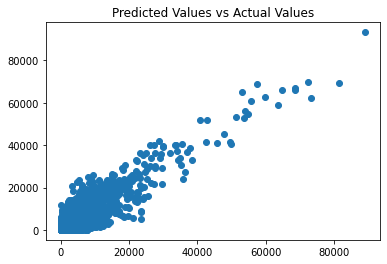

In [9]:
myPredMetric(prediction, testy, 100)

In [10]:
model.score(poly_testx, testy) # this is not a good metric because I am using the prediction more as a threshold as shown above

0.7633130176823741

In [11]:
#   
#   this is a function that takes input from a potential user
#    --> prints Predicted Sales, and Tickets Sold based on Prediction and given ticket price

def predictTicketSales( film_code, cinema_code, ticket_price, show_time, capacity, month, quarter, day): # day index calc by function

  monthNum = {1: 0, 2: 31, 3: 59, 4: 90, 5: 120, 6: 151, 7: 181, 8: 212, 9:243, 10: 273, 11: 304, 12: 334 }
  day_index = (monthNum[month] + day)

  inputs = [(film_code, cinema_code, ticket_price, day_index, show_time, capacity, month, quarter, day)]
  
  
  prediction = model.predict(polyTransf.transform(inputs))

  tSales = prediction / ticket_price
  if(tSales > capacity):
    prediction = capacity*ticket_price

  if(prediction <= 0):
    prediction = 0
    tSales = 0

  print('Total Predicted Ticket Sales: %.2f' % (tSales))
  print('Total Predicted Sales: %.2f\n' % (prediction))

In [12]:
# film_code, cinema_code, ticket_price, show_time, capacity, month, quarter, day

predictTicketSales(1492, 304, 15, 4, 200, 5, 2, 5)

predictTicketSales(1500, 352, 8, 5,  300, 5, 2, 5)

Total Predicted Ticket Sales: 7.58
Total Predicted Sales: 113.63

Total Predicted Ticket Sales: 31.82
Total Predicted Sales: 254.54



The final function predictTicketSales() would be an example of where the user's information is input in and predictions would be returned for the user. 

The user would know their cinema code- maybe they are one of a larger organization and this algorithm is used by the whole company. I included film code in the case of a theater that may play older movies that already have data associated with them. In the case of a theater that only plays new movies, this would be irrelevant. Ticket price, show time, and the day of the movie playing are all things that the user can change to optimize sales. 

In [13]:
from joblib import dump, load 
dump(model, 'predTS.pkl')

['predTS.pkl']